In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка изображения
image_path = '/content/Акринский-кот.jpg'
image = Image.open(image_path).convert('RGB')

# Преобразование изображения в тензор
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0)

# Добавление размытия
def add_blur(image, kernel_size=5):
    return transforms.functional.gaussian_blur(image, kernel_size)

blurred_image = add_blur(image_tensor)

# Диффузионная модель
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DiffusionModel()




In [8]:
# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(blurred_image)
    loss = criterion(output, image_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0158
Epoch [20/100], Loss: 0.0078
Epoch [30/100], Loss: 0.0043
Epoch [40/100], Loss: 0.0029
Epoch [50/100], Loss: 0.0018
Epoch [60/100], Loss: 0.0012
Epoch [70/100], Loss: 0.0010
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0008
Epoch [100/100], Loss: 0.0007


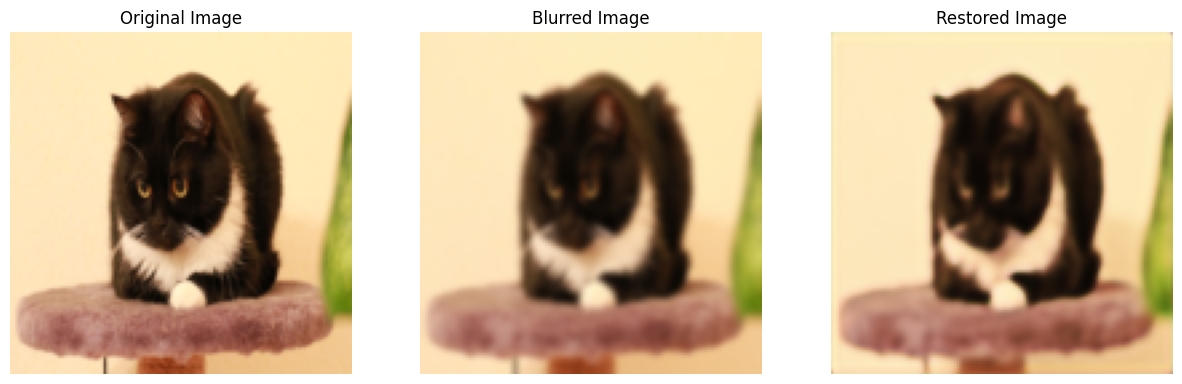

In [9]:
# Визуализация результатов
model.eval()
with torch.no_grad():
    restored_image = model(blurred_image)

# Сохранение изображений
save_image(blurred_image.squeeze(0), 'blurred_image.png')
save_image(restored_image.squeeze(0), 'restored_image.png')

# Отображение изображений
def imshow(image, title):
    image = image.cpu().squeeze(0).permute(1, 2, 0)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
imshow(image_tensor, 'Original Image')
plt.subplot(1, 3, 2)
imshow(blurred_image, 'Blurred Image')
plt.subplot(1, 3, 3)
imshow(restored_image, 'Restored Image')
plt.show()